In [70]:
import Pkg
Pkg.activate("../../Tasks2D/")

  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
using Revise
includet("src/model2.jl")
# Loads in: model_init, motion_model, observe_noisy_distances

include("src/action_controllers.jl");
# Loads in: meandering_wallavoiding_controller

In [3]:
import LinearAlgebra

In [4]:
# POMDP for an agent moving around in the environment
pomdp = GenPOMDPs.GenPOMDP(
    model_init,              # INIT   : params                     ⇝ state
    motion_model,            # STEP   : prev_state, action, params ⇝ state
    observe_noisy_distances, #| OBS    : state, params              ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params      → utility
);

Set up several distributions over POMDP rollouts.  We'll use these distributions to generate data to run inference in.

In [5]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, meandering_wallavoiding_controller);

Some default POMDP params:

In [6]:
_get_params(map) = (;
    # map = GridWorlds.load_custom_map(5),
    map=map,
    step = (; Δ = .5, σ_windy = 0.5, σ_normal = 0.05),
    obs = (; fov = 2π, n_rays = 90, orientation = π/2,
        # I think currently only σ is used
        wall_sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0, σ=0.005
        )
    ),
    init_wind_prob = 0.02,
    become_windy_prob = 0.02,
    stay_windy_prob = 0.9
)

MAPSTR = """
wwwwwwwwwwwwwwwww
w               w
w        w      w
w        w      w
w        w      w
w        w      w
w               w
w               w
w               w
wwwwwwwwwwwwwwwww
"""
params = _get_params(GridWorlds.mapstr_to_gridworld(MAPSTR));

Test data generation:

In [7]:
trace = Gen.simulate(rollout_model, (100, params))
GenPOMDPs.state_sequence(trace)[1:10]

10-element Vector{@NamedTuple{pos::Vector{Float64}, is_windy::Bool, t::Int64, hit_wall::Bool}}:
 (pos = [15.177512501893577, 1.5704540660807438], is_windy = 0, t = 0, hit_wall = 0)
 (pos = [15.174239943785816, 2.0692862313533986], is_windy = 0, t = 1, hit_wall = 0)
 (pos = [14.62321658550857, 2.0217926600422573], is_windy = 0, t = 2, hit_wall = 0)
 (pos = [14.096269372586107, 2.0407602891984773], is_windy = 0, t = 3, hit_wall = 0)
 (pos = [14.06715240796289, 2.565331374694707], is_windy = 0, t = 4, hit_wall = 0)
 (pos = [14.078265692973664, 3.1373073395261524], is_windy = 0, t = 5, hit_wall = 0)
 (pos = [14.0813690095282, 3.5232481409852596], is_windy = 0, t = 6, hit_wall = 0)
 (pos = [14.523875597646889, 3.4710791261500353], is_windy = 0, t = 7, hit_wall = 0)
 (pos = [14.942301020280269, 3.520247150636779], is_windy = 0, t = 8, hit_wall = 0)
 (pos = [14.945958323811242, 3.9979604758255975], is_windy = 0, t = 9, hit_wall = 0)

In [8]:
GenPOMDPs.action_sequence(trace)[1:10]

10-element Vector{Symbol}:
 :up
 :left
 :left
 :up
 :up
 :up
 :right
 :right
 :up
 :up

In [ ]:
includet("src/viz_constructors.jl")
trace_gif(trace)

### Inference POMDP

In [10]:
@gen function ipomdp_init(params)
    state ~ model_init(params.params)
    return state
end
@gen function ipomdp_step(prev, inference_action, params)
    action = params.actions[prev.t + 1]
    state ~ motion_model(prev, action, params.params)
    return state
end
@gen function ipomdp_obs(prev, params)
    observation ~ observe_noisy_distances(prev, params.params)
    return observation
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##ipomdp_obs#552", Bool[0, 0], false)

In [11]:
"""
    InferenceAction(found_position:Bool, inferred_position::Vector, inference_runtime::Float64)
- found_position - did the inference algorithm find a position, or give up?
- inferred_position - the position that the inference algorithm inferred, if any
- inference_runtime is the time it took to run the inference algorithm, in milliseconds.
"""
InferenceAction = NamedTuple{
    (:found_position, :inferred_position, :inference_runtime),
    Tuple{Bool, Vector{Float64}, Float64}
}
function errcost(pos, ia::InferenceAction)
    if ia.found_position
        return LinearAlgebra.norm(pos - ia.inferred_position)^2
    else
        return 1.
    end
end
function timecost(ia::InferenceAction)
    # Scale inference runtime by 2000, so it is better to spend
    # 2 seconds and get the position right than to totally give up.
    return ia.inference_runtime/2000
end
function cost(pos, ia::InferenceAction)
    return errcost(pos, ia) + timecost(ia)
end

inference_pomdp = GenPOMDPs.GenPOMDP(
    ipomdp_init,
    ipomdp_step,
    ipomdp_obs,
    # Utility = -cost
    (state, inference_action) -> -cost(state.pos, inference_action)
);

In [12]:
function is_err(pos, ia)
    return LinearAlgebra.norm(ia.inferred_position - pos) > 0.3
end
function n_errors(itrace::Gen.Trace)
    return sum(
        is_err(state.pos, ia) for (state, ia) in zip(
            GenPOMDPs.state_sequence(itrace),
            GenPOMDPs.action_sequence(itrace)
        )
    )
end
function errcost(itrace::Gen.Trace)
    return sum(
        errcost(state.pos, ia) for (state, ia) in zip(
            GenPOMDPs.state_sequence(itrace),
            GenPOMDPs.action_sequence(itrace)
        )
    )

end
function timecost(itrace::Gen.Trace)
    return sum(
        timecost(ia) for ia in GenPOMDPs.action_sequence(itrace)
    )
end

timecost (generic function with 2 methods)

In [13]:
function pomdp_to_ipomdp_choicemap(pomdp_choicemap, T)
    cm = choicemap()
    for t=0:T
        Gen.set_submap!(cm, GenPOMDPs.state_addr(t, :state),
            get_submap(pomdp_choicemap, GenPOMDPs.state_addr(t))
        )
        Gen.set_submap!(cm, GenPOMDPs.obs_addr(t, :observation),
            get_submap(pomdp_choicemap, GenPOMDPs.obs_addr(t))
        )
    end
    return cm
end

pomdp_to_ipomdp_choicemap (generic function with 1 method)

In [14]:
ictm = GenPOMDPs.ControlledTrajectoryModel(inference_pomdp)
ias = [InferenceAction((true, x.pos, 0.)) for x in GenPOMDPs.state_sequence(trace)]
ipomdp_params = (params=params, actions=GenPOMDPs.action_sequence(trace))
itrace, _ = GenPOMDPs.generate(
    ictm, (100, ias, ipomdp_params),
    GenPOMDPs.nest_choicemap(
        get_submap(get_choices(trace), GenPOMDPs.state_addr(0)),
        GenPOMDPs.nest_at(GenPOMDPs.state_addr(0), :state)
    )
)
GenPOMDPs.undiscounted_utility(inference_pomdp, itrace)

-379.83213035884637

In [15]:
GenPOMDPs.state_sequence(itrace)[1]

(pos = [15.177512501893577, 1.5704540660807438], is_windy = false, t = 0, hit_wall = false)

In [16]:
GenPOMDPs.state_sequence(trace)[1]

(pos = [15.177512501893577, 1.5704540660807438], is_windy = false, t = 0, hit_wall = false)

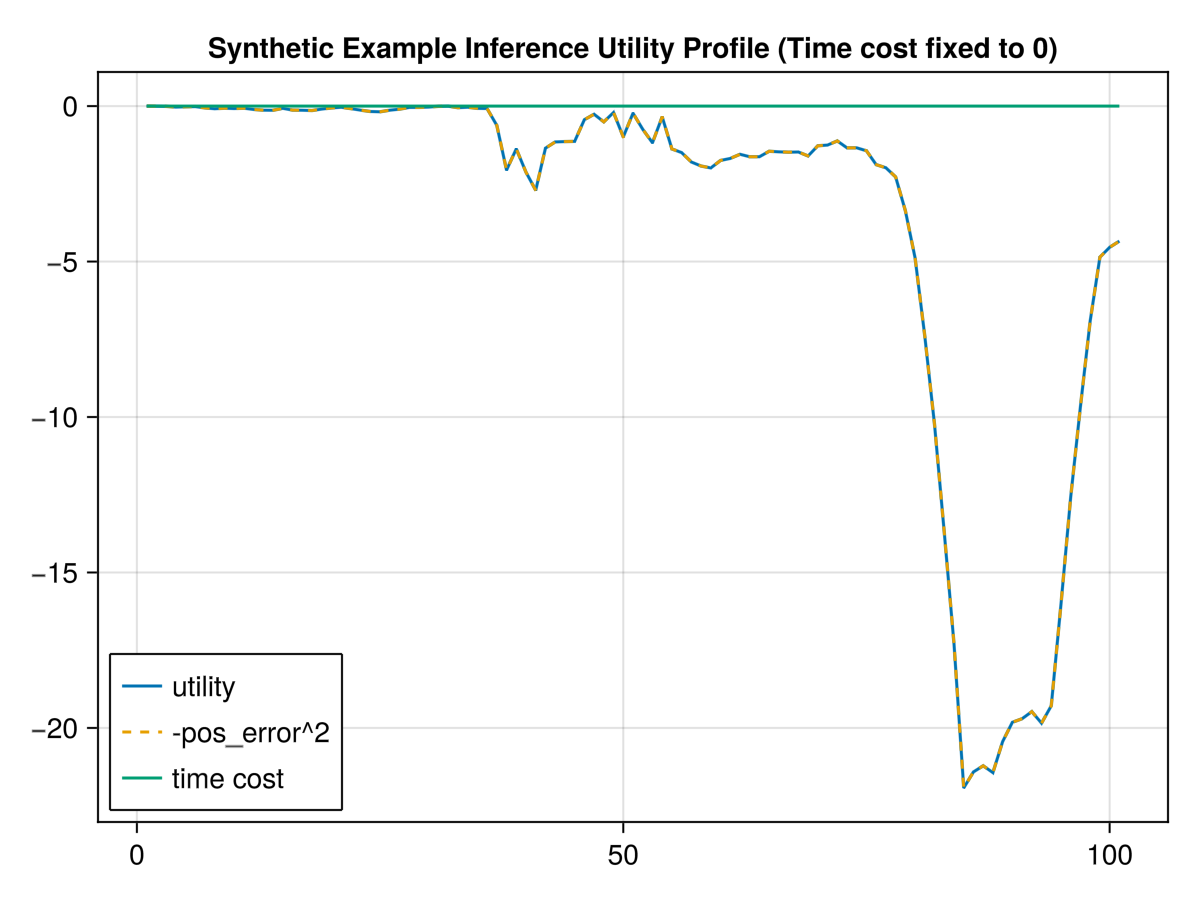

In [17]:
import Makie
import GLMakie
sas = zip(GenPOMDPs.state_sequence(itrace), GenPOMDPs.action_sequence(itrace))
f = Makie.lines(
    [inference_pomdp.utility(s, a) for (s, a) in sas],
    label="utility",
    axis=(;title="Synthetic Example Inference Utility Profile (Time cost fixed to 0)")
)
Makie.lines!([-errcost(s.pos, a) for (s, a) in sas], label="-pos_error^2", linestyle=:dash)
Makie.lines!([-timecost(a) for (s, a) in sas], label="time cost")
Makie.axislegend(position=:lb)
f

Unsurprisingly, this has quite a high cost.  Would have been way better to just report "we don't konw" at each time step.

Also note that the time cost here is meaningless (we just said the time was 0 for each step).

Now we'll start actually implementing inference, to hopefully do better.

In [18]:
function get_timed_inference_controller(_inference_controller)
    @gen function timed_inference_controller(cstate, observation)
        t = time()
        new_cstate, inference_action = {:inner} ~ _inference_controller(cstate, observation)
        Δt = time() - t
        
        return InferenceAction((inference_action.found_position, inference_action.inferred_position, Δt)), new_cstate
    end
    return timed_inference_controller
end

get_timed_inference_controller (generic function with 1 method)

In [19]:
include("src/inference_constructors.jl")

make_pf (generic function with 1 method)

In [20]:
FixedPFControllerState = NamedTuple{
    (:pf, :ipomdp_params, :pfstate),
    Tuple{Any, Any, Any}
}
# Main inference controller function
@gen function __fixed_pf_inference_controller(cstate, observation)
    pf_init, pf_update = cstate.pf
    observation = choicemap((:obs, observation))
    if isnothing(cstate.pfstate)
        # Initialize the PF
        new_pf_state = pf_init(observation)
    else
        # Update the PF
        t = GenPOMDPs.state_sequence(cstate.pfstate.traces[1])[end].t + 1
        action = cstate.ipomdp_params.actions[t]
        new_pf_state = pf_update(cstate.pfstate, action, observation)
    end

    tr = Gen.sample_unweighted_traces(new_pf_state, 1)[1]
    inference_action = InferenceAction((true, GenPOMDPs.state_sequence(tr)[end].pos, NaN))
    new_cstate = FixedPFControllerState((cstate.pf, cstate.ipomdp_params, new_pf_state))
    return new_cstate, inference_action
end
_fixed_pf_inference_controller = get_timed_inference_controller(__fixed_pf_inference_controller)

# Initialize the inference controller with the params, and no
# inference state (it will initialize the PF itself)
bpf_2particle_inference_controller = GenPOMDPs.Controller(
    _fixed_pf_inference_controller,
    FixedPFControllerState((make_bpf(pomdp, params, 2), ipomdp_params, nothing))
);

In [21]:
bpf_inference_rollout_model = GenPOMDPs.RolloutModel(inference_pomdp, bpf_2particle_inference_controller)
bpf_itrace, _ = GenPOMDPs.generate(
    bpf_inference_rollout_model, (10, ipomdp_params),
    pomdp_to_ipomdp_choicemap(get_choices(trace), 10)
);

In [22]:
bpf_itrace_ext, _ = Gen.update(
    bpf_itrace, (100, ipomdp_params), (Gen.UnknownChange(), Gen.NoChange()),
    pomdp_to_ipomdp_choicemap(get_choices(trace), 100)
);

In [23]:
GenPOMDPs.undiscounted_utility(inference_pomdp, bpf_itrace_ext)

-26.1380984547543

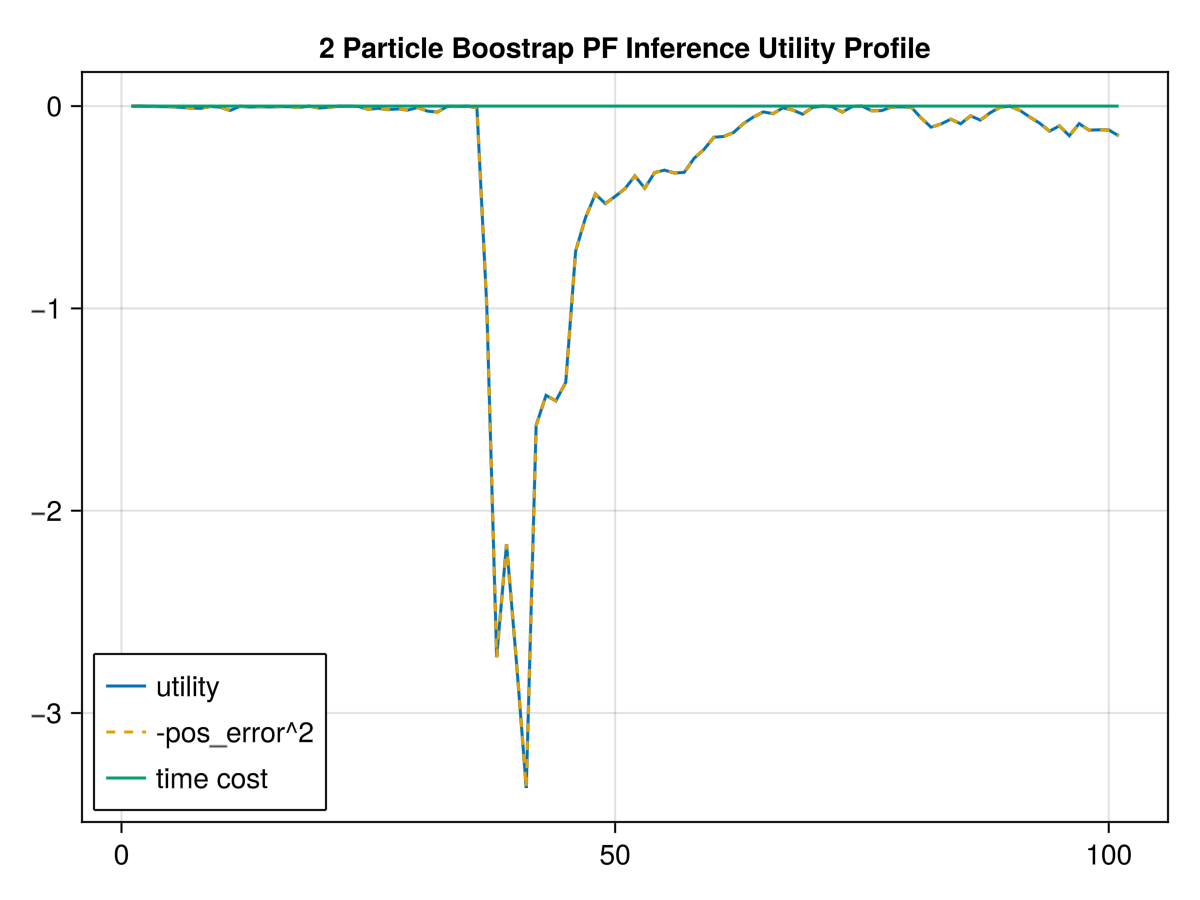

In [24]:
sas = zip(GenPOMDPs.state_sequence(bpf_itrace_ext), GenPOMDPs.action_sequence(bpf_itrace_ext))
f = Makie.lines(
    [inference_pomdp.utility(s, a) for (s, a) in sas],
    label="utility",
    axis=(;title="2 Particle Boostrap PF Inference Utility Profile")
)
Makie.lines!([-errcost(s.pos, a) for (s, a) in sas], label="-pos_error^2", linestyle=:dash)
Makie.lines!([-timecost(a) for (s, a) in sas], label="time cost")
Makie.axislegend(position=:lb)
f

In [ ]:
include("src/viz_constructors.jl")

pf_result_gif(bpf_itrace_ext)

In [26]:
include("src/inference_constructors.jl")
function FixedC2FInferenceController(sigma_multiplier, coarsest_stepsize)
    return GenPOMDPs.Controller(
        _fixed_pf_inference_controller,
        FixedPFControllerState((
            make_c2f_pf(pomdp, params, 2; sigma_multiplier, coarsest_stepsize),
            ipomdp_params, nothing)
        )
    )
end
fixed_c2f_ic = FixedC2FInferenceController(4, 0.2)
fixed_c2f_rollout_model = GenPOMDPs.RolloutModel(inference_pomdp, fixed_c2f_ic)
c2f_itrace, _ = GenPOMDPs.generate(
    fixed_c2f_rollout_model, (10, ipomdp_params),
    pomdp_to_ipomdp_choicemap(get_choices(trace), 10)
);

In [27]:
c2f_itrace_ext, _ = Gen.update(
    c2f_itrace, (100, ipomdp_params), (Gen.UnknownChange(), Gen.NoChange()),
    pomdp_to_ipomdp_choicemap(get_choices(trace), 100)
);

In [28]:
GenPOMDPs.undiscounted_utility(inference_pomdp, c2f_itrace_ext)

-0.02825388845296748

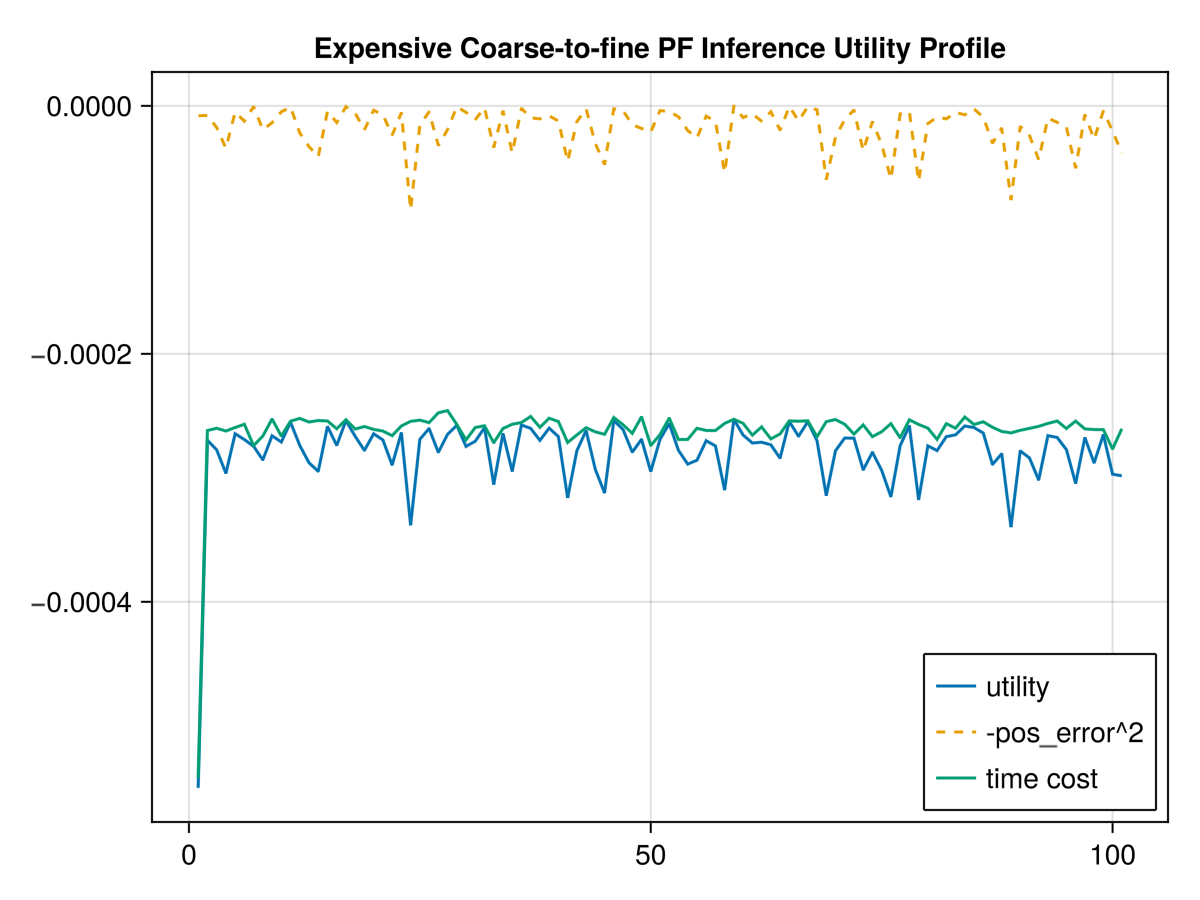

In [29]:
sas = zip(GenPOMDPs.state_sequence(c2f_itrace_ext), GenPOMDPs.action_sequence(c2f_itrace_ext))
f = Makie.lines(
    [inference_pomdp.utility(s, a) for (s, a) in sas],
    label="utility",
    axis=(;title="Expensive Coarse-to-fine PF Inference Utility Profile")
)
Makie.lines!([-errcost(s.pos, a) for (s, a) in sas], label="-pos_error^2", linestyle=:dash)
Makie.lines!([-timecost(a) for (s, a) in sas], label="time cost")
Makie.axislegend(position=:rb)
f

With the particular way we are scaling time cost in this inference POMDP, you can see that the decision-theoretic cost is dominated by the runtime of inference, and the error in the inferred positions is very low.

For reference, here is amount of time per step, unscaled:

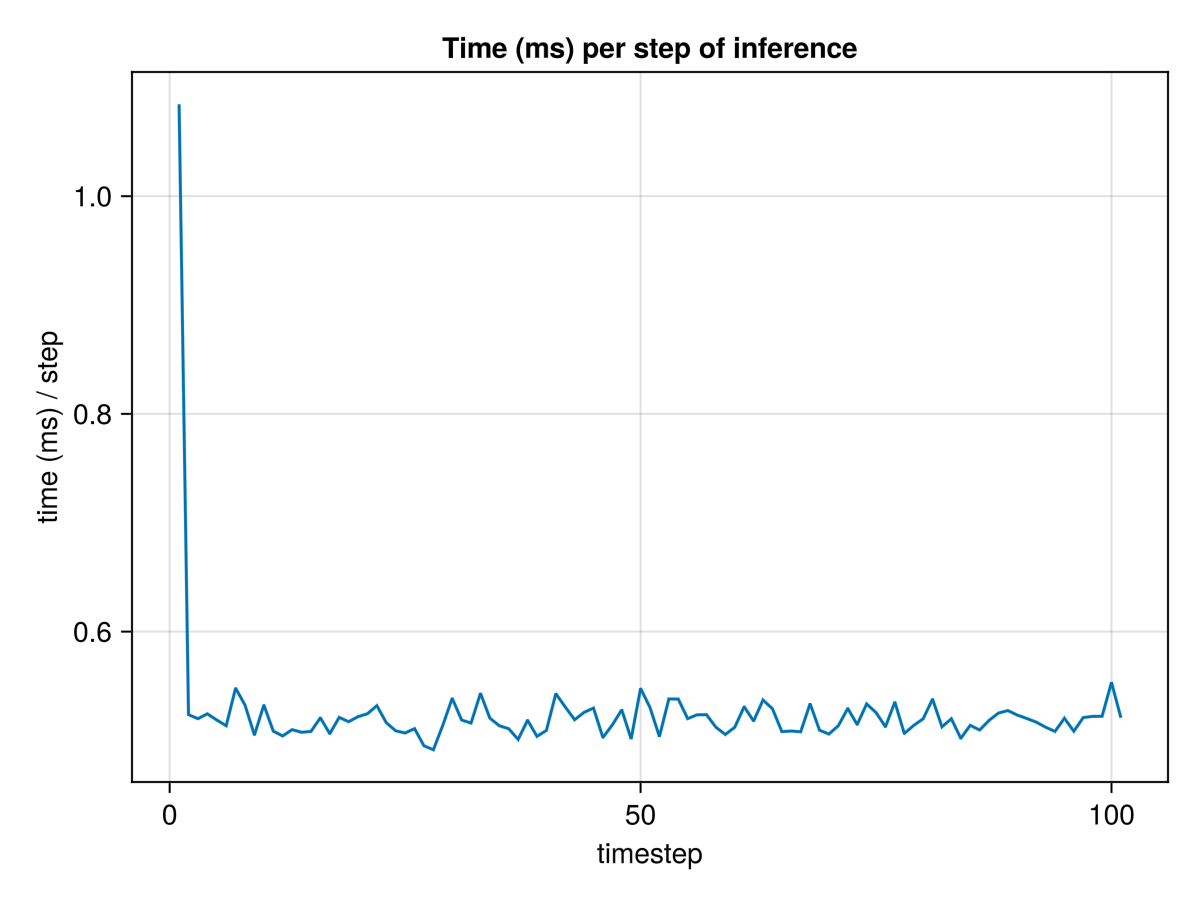

In [30]:
Makie.lines(
    [a.inference_runtime for (s, a) in sas],
    axis=(;title="Time (ms) per step of inference", xlabel="timestep", ylabel="time (ms) / step")
)

# Interesting -- it seems like the cost is slowly increasing over time.
# This is probably because the asymptotics of the `Gen.update` call in the
# SMCP3 proposal on the wind level are wrong.  I can fix this later if it
# becvomes important.

The inference results look like this:

In [ ]:
pf_result_gif(c2f_itrace_ext)

### Adaptive inference controller

Now I'll implement a Gen.Controller for the inference POMDP which gradually expands the C2F schedule while it looks like its inference attempt so far hasn't worked.

In [32]:
ICParams = NamedTuple{
    (:pf_init_sequence, :pf_update_sequence, :threshold)
}
AdaptiveInferenceControllerState = NamedTuple{
    (:ic_params, :ipomdp_params, :pfstate),
    Tuple{Any, Any, Any}
}
function fails_threshold_test(pfstate, threshold)
    tr = Gen.sample_unweighted_traces(pfstate, 1)[1]
    score = Gen.project(tr, select(GenPOMDPs.obs_addr(get_args(tr)[1])))
    return score < threshold
end
@gen function __adaptive_pf_init(ic_params, obs)
    i = 1
    pfstate = ic_params.pf_init_sequence[i](obs)
    while fails_threshold_test(pfstate, ic_params.threshold) && i < length(ic_params.pf_init_sequence)
        i += 1
        pfstate = ic_params.pf_init_sequence[i](obs)
    end
    return pfstate
end
@gen function __adaptive_pf_update(ic_params, prev_pfstate, action, obs)
    i = 1
    pfstate = ic_params.pf_update_sequence[i](prev_pfstate, action, obs)
    while fails_threshold_test(pfstate, ic_params.threshold) && i < length(ic_params.pf_update_sequence)
        i += 1
        pfstate = ic_params.pf_update_sequence[i](prev_pfstate, action, obs)
    end
    return pfstate
end
@gen function __adaptive_inference_controller(cstate, observation)
    observation = choicemap((:obs, observation))
    if isnothing(cstate.pfstate)
        new_pf_state = __adaptive_pf_init(cstate.ic_params, observation)
    else
        # Update the PF
        t = GenPOMDPs.state_sequence(cstate.pfstate.traces[1])[end].t + 1
        action = cstate.ipomdp_params.actions[t]
        new_pf_state = __adaptive_pf_update(cstate.ic_params, cstate.pfstate, action, observation)
    end

    tr = Gen.sample_unweighted_traces(new_pf_state, 1)[1]
    inference_action = InferenceAction((true, GenPOMDPs.state_sequence(tr)[end].pos, NaN))
    new_cstate = AdaptiveInferenceControllerState((cstate.ic_params, cstate.ipomdp_params, new_pf_state))
    return new_cstate, inference_action
end
_adaptive_inference_controller = get_timed_inference_controller(__adaptive_inference_controller)

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##timed_inference_controller#650#183"{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##__adaptive_inference_controller#1663", Bool[0, 0], false)), Bool[0, 0], false)

### Tune thresholds

In [33]:
# Generate data

n_steps_calibration = 100
n_calibration_trs = 1000
calibration_trs = [Gen.simulate(rollout_model, (n_steps_calibration, params)) for _ in 1:n_calibration_trs];
obs_log_likelihoods = [
    Gen.project(tr, select(GenPOMDPs.obs_addr(step)))
    for tr in calibration_trs, step in 1:n_steps_calibration
];

In [34]:
get_percentile_threshold(percentile) = sort(collect(Iterators.flatten(obs_log_likelihoods)))[Int(length(obs_log_likelihoods) * percentile/100)]
threshold_1_in_10000 = get_percentile_threshold(0.01)
threshold_1_in_1000 = get_percentile_threshold(0.1)
threshold_1_in_100 = get_percentile_threshold(1.0);

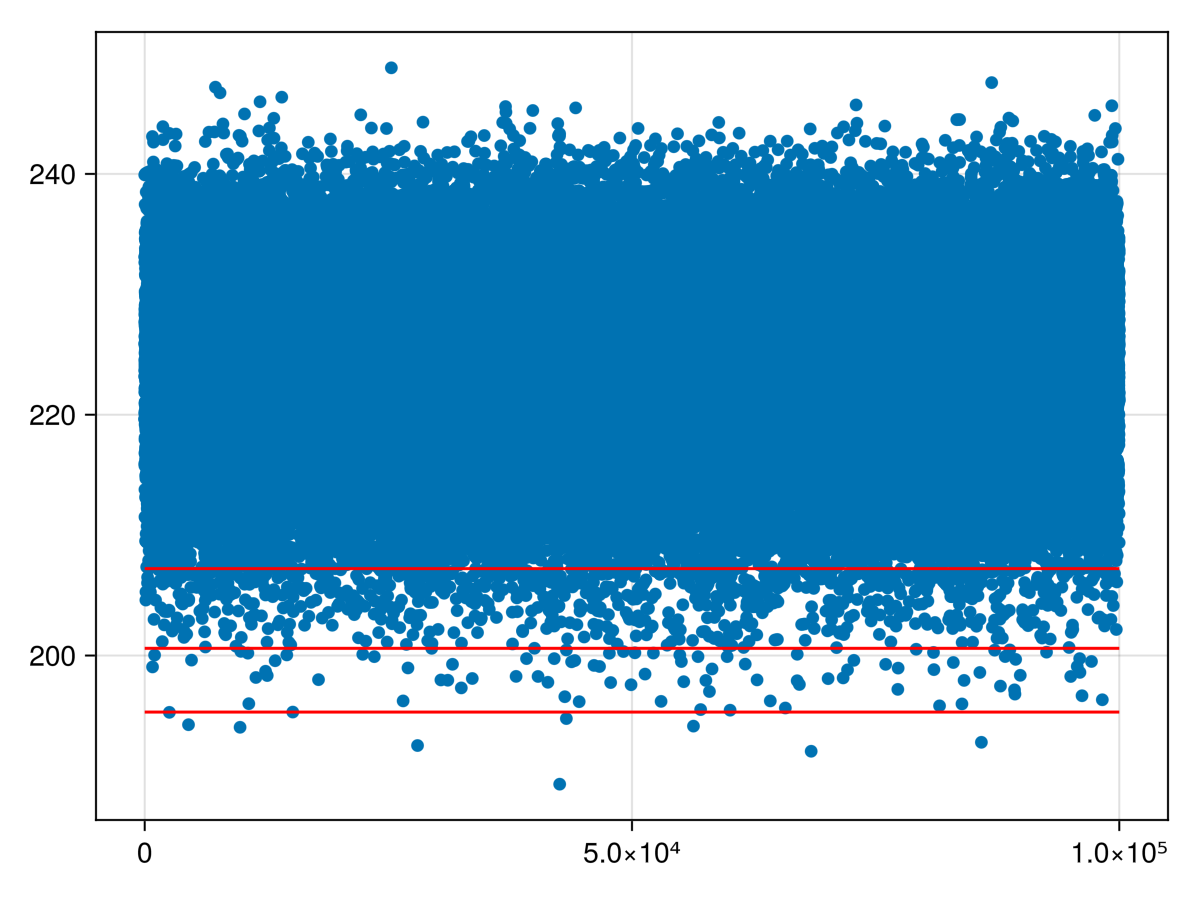

In [35]:
f = Makie.scatter(collect(Iterators.flatten(obs_log_likelihoods)), )
Makie.lines!([0, length(obs_log_likelihoods)] ,[threshold_1_in_100, threshold_1_in_100], color=:red)
Makie.lines!([0, length(obs_log_likelihoods)] ,[threshold_1_in_1000, threshold_1_in_1000], color=:red)
Makie.lines!([0, length(obs_log_likelihoods)] ,[threshold_1_in_10000, threshold_1_in_10000], color=:red)
f

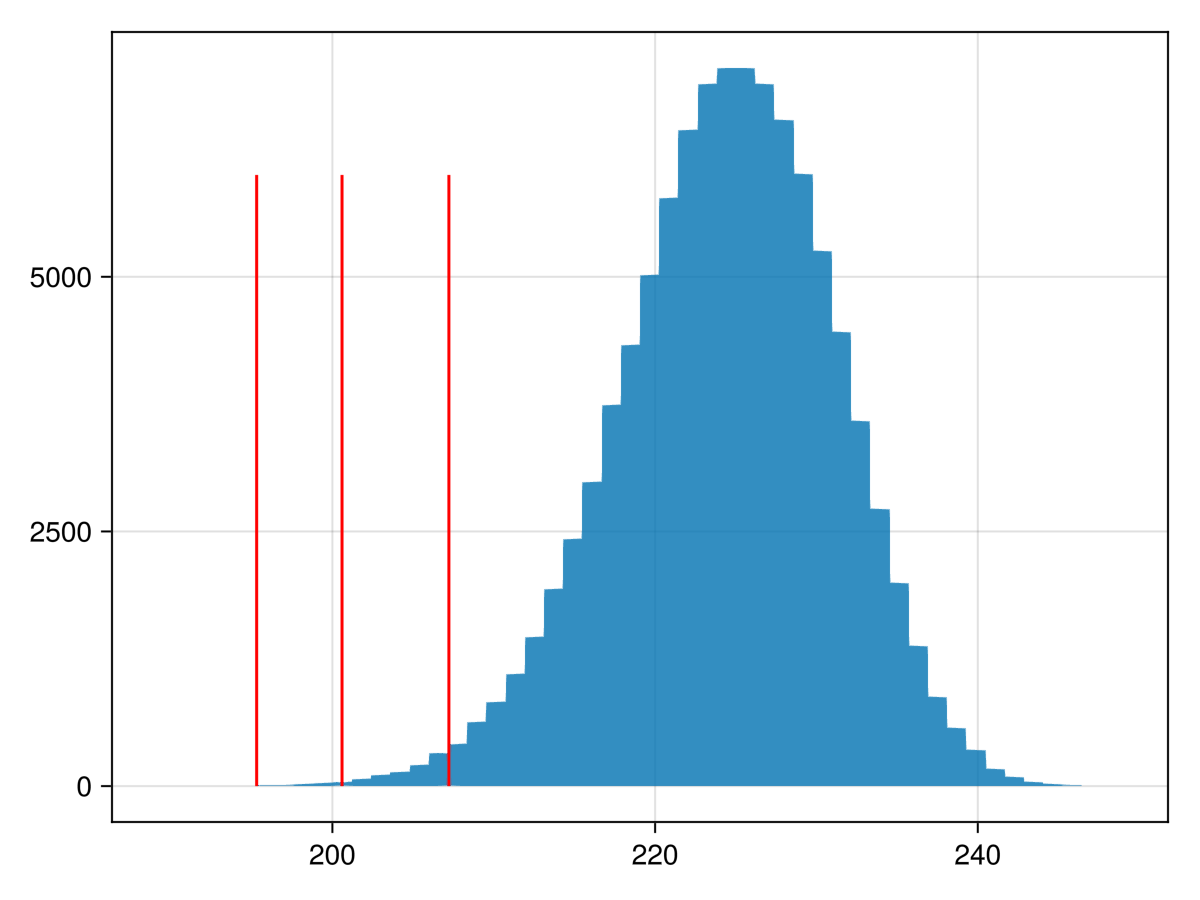

In [36]:
f = Makie.hist(
    collect(Iterators.flatten(obs_log_likelihoods)),
    bins=50,
    normalize=true
)
Makie.lines!([threshold_1_in_100, threshold_1_in_100], [0, 6000], color=:red)
Makie.lines!([threshold_1_in_1000, threshold_1_in_1000], [0, 6000], color=:red)
Makie.lines!([threshold_1_in_10000, threshold_1_in_10000], [0, 6000], color=:red)
f


### Construct + run concrete inference controller

In [37]:
pf_init_sequence = [
    make_c2f_pf(pomdp, params, 1; sigma_multiplier=m, coarsest_stepsize=r)[1]
    for (m, r) in [(1., 0.4), (1, 0.2), (1, 0.1)]
]
pf_update_sequence = [
    make_c2f_pf(pomdp, params, 1; sigma_multiplier=m, coarsest_stepsize=r)[2]
    for (m, r) in [(0.5, 0.4), (1.5, 0.4), (2.5, 0.2), (4., 0.2), (5., 0.1)]

]
adaptive_inference_controller = GenPOMDPs.Controller(
    _adaptive_inference_controller,
    AdaptiveInferenceControllerState((
        ICParams((pf_init_sequence, pf_update_sequence, threshold_1_in_1000)),
        ipomdp_params, nothing)
    )
);

In [38]:
aic_rollout_model = GenPOMDPs.RolloutModel(inference_pomdp, adaptive_inference_controller)
aic_itrace, _ = GenPOMDPs.generate(
    aic_rollout_model, (10, ipomdp_params),
    pomdp_to_ipomdp_choicemap(get_choices(trace), 10)
);

In [39]:
aic_itrace_ext, _ = Gen.update(
    aic_itrace, (100, ipomdp_params), (Gen.UnknownChange(), Gen.NoChange()),
    pomdp_to_ipomdp_choicemap(get_choices(trace), 100)
);

In [40]:
GenPOMDPs.undiscounted_utility(inference_pomdp, bpf_itrace_ext)

-26.1380984547543

In [41]:
include("src/inference_constructors.jl")

make_pf (generic function with 1 method)

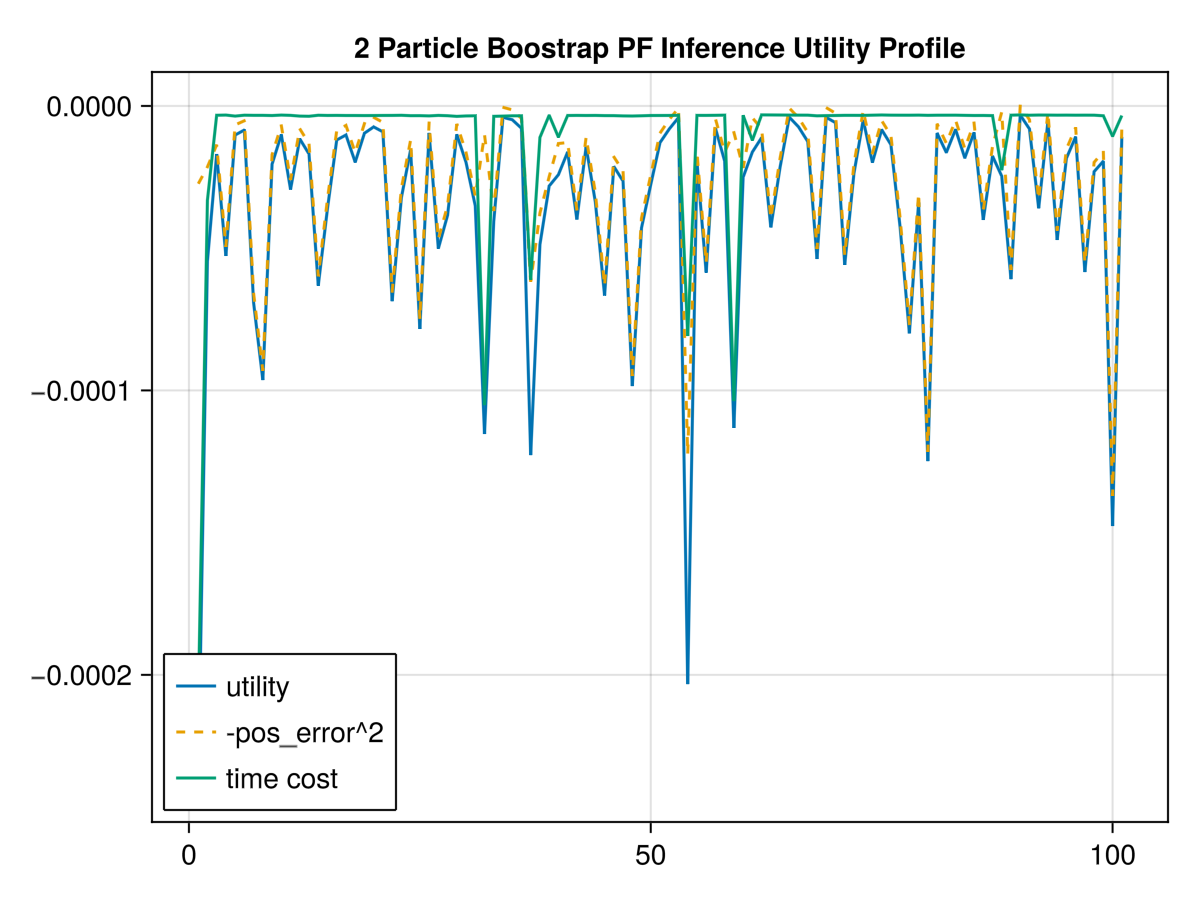

In [42]:
sas = zip(GenPOMDPs.state_sequence(aic_itrace_ext), GenPOMDPs.action_sequence(aic_itrace_ext))
f = Makie.lines(
    [inference_pomdp.utility(s, a) for (s, a) in sas],
    label="utility",
    axis=(;title="2 Particle Boostrap PF Inference Utility Profile")
)
Makie.lines!([-errcost(s.pos, a) for (s, a) in sas], label="-pos_error^2", linestyle=:dash)
Makie.lines!([-timecost(a) for (s, a) in sas], label="time cost")
Makie.axislegend(position=:lb)
f

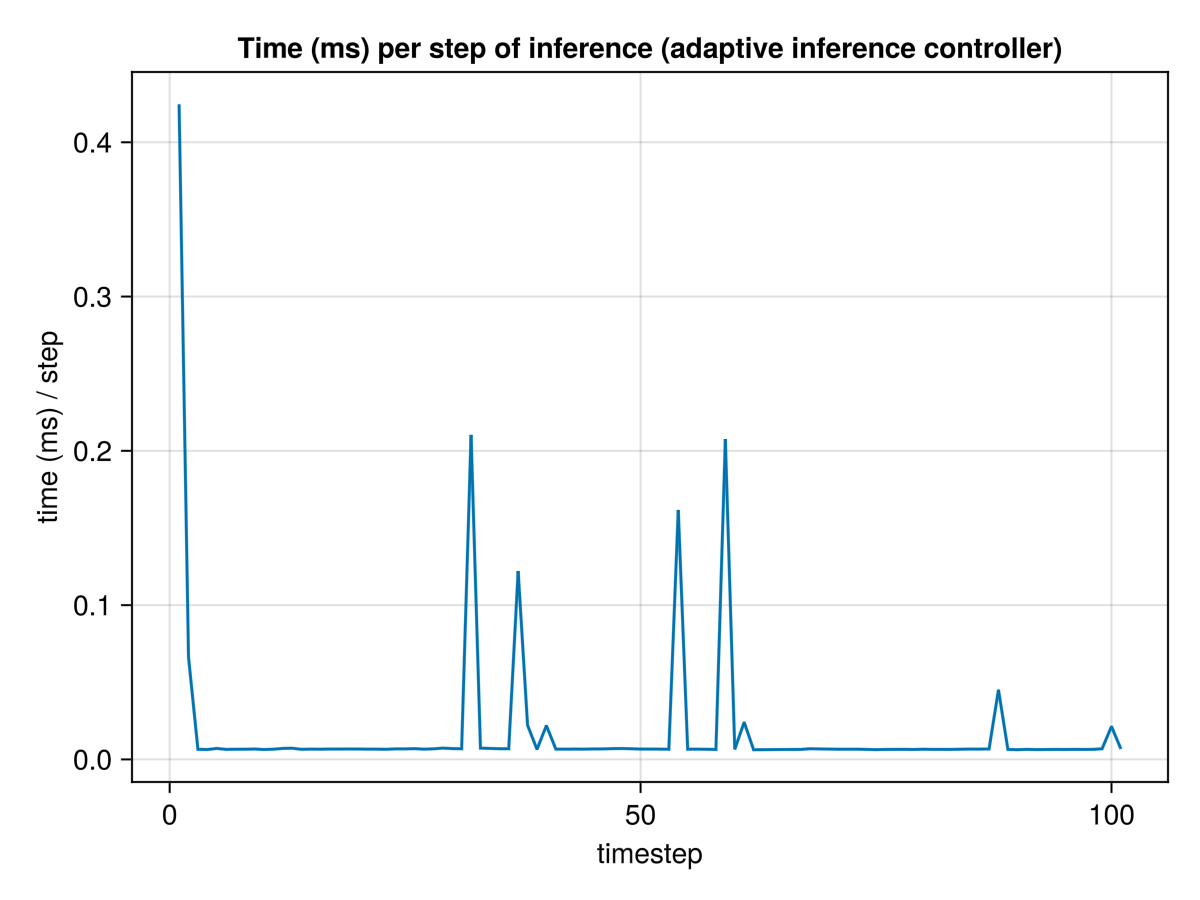

In [43]:
Makie.lines(
    [a.inference_runtime for (s, a) in sas],
    axis=(;title="Time (ms) per step of inference (adaptive inference controller)", xlabel="timestep", ylabel="time (ms) / step")
)

In [ ]:
pf_result_gif(aic_itrace_ext)

### Comparison of inference algorithms

Single run time comparison:

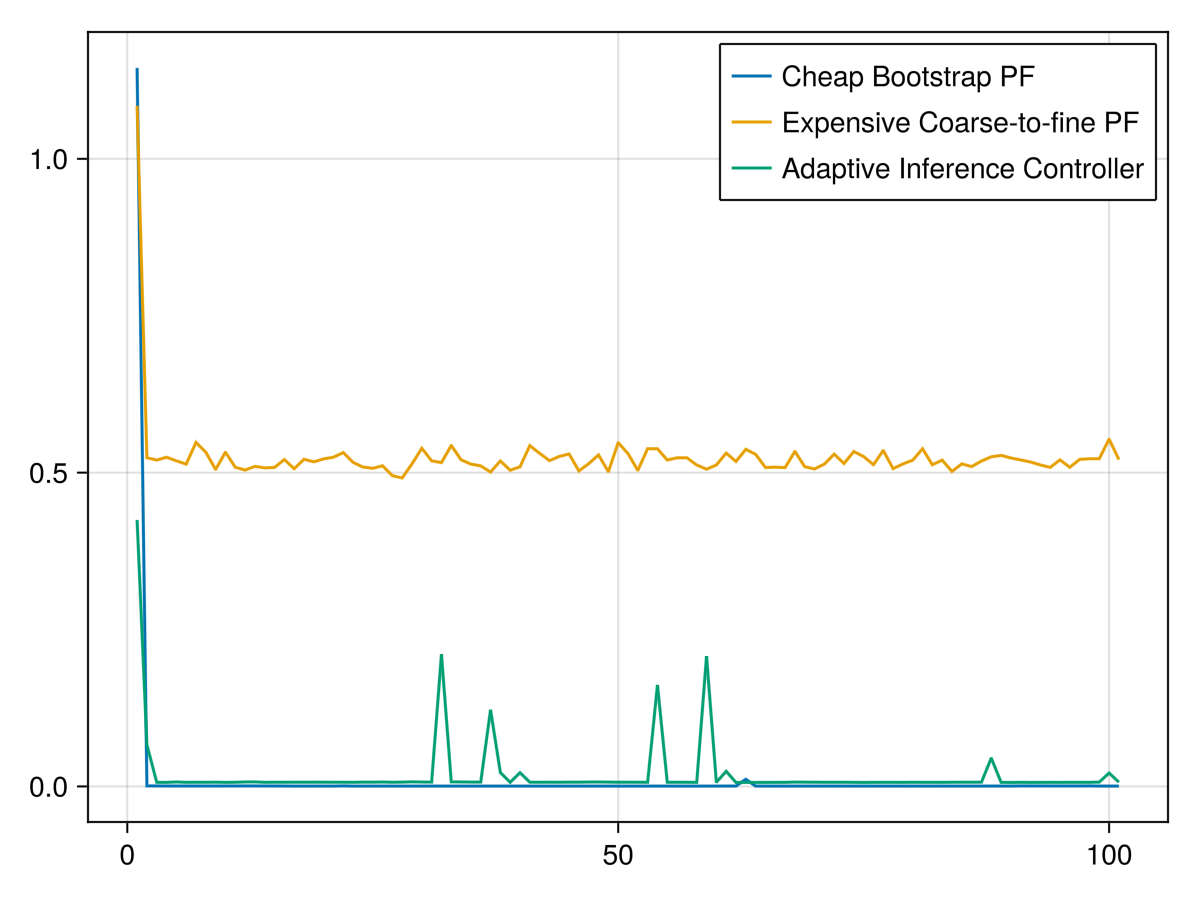

In [45]:
labeled_ipomdp_traces = [
    (bpf_itrace_ext, "Cheap Bootstrap PF"),
    (c2f_itrace_ext, "Expensive Coarse-to-fine PF"),
    (aic_itrace_ext, "Adaptive Inference Controller")
]
timeseqs = [
    [a.inference_runtime for a in GenPOMDPs.action_sequence(tr)]
    for (tr, label) in labeled_ipomdp_traces
]
f = Makie.Figure(); ax = Makie.Axis(f[1, 1])
for (ts, (_, label)) in zip(timeseqs, labeled_ipomdp_traces)
    Makie.lines!(ax, ts, label=label)
end
Makie.axislegend()
f

Time vs error rate comparison:

In [64]:
# These 3 parameters will control how long it takes to generate
# the data here.
sigma_multipliers = [0.5, 2., 4.] # [0.5, 1., 2., 4.] # [0.5, 1., 2., 4.] #[0.5, 1., 2., 3., 4., 5.]
n_traces = 20 #8
trace_len = 100

100

In [65]:
ic_groups = [
    ("Adaptive Inference Controller", [adaptive_inference_controller]),
    ("Fixed Schedule Inference; Coarsest Grid Step Size = 0.2", [
        FixedC2FInferenceController(s, 0.2) for s in sigma_multipliers
    ]),
    ("Fixed Schedule Inference; Coarsest Grid Step Size = 0.4", [
        FixedC2FInferenceController(s, 0.4) for s in sigma_multipliers
    ])
]
ipomdp_rollout_model_groups = [
    (label, [GenPOMDPs.RolloutModel(inference_pomdp, ic) for ic in ics])
    for (label, ics) in ic_groups
]

3-element Vector{Tuple{String, Vector}}:
 ("Adaptive Inference Controller", GenPOMDPs.var"##StaticGenFunction__RolloutModel#11336"[GenPOMDPs.var"##StaticGenFunction__RolloutModel#11336"(Dict{Symbol, Any}(), Dict{Symbol, Any}())])
 ("Fixed Schedule Inference; Coarsest Grid Step Size = 0.2", Gen.StaticIRGenerativeFunction{Any}[GenPOMDPs.var"##StaticGenFunction__RolloutModel#11426"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), GenPOMDPs.var"##StaticGenFunction__RolloutModel#11516"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), GenPOMDPs.var"##StaticGenFunction__RolloutModel#11606"(Dict{Symbol, Any}(), Dict{Symbol, Any}())])
 ("Fixed Schedule Inference; Coarsest Grid Step Size = 0.4", Gen.StaticIRGenerativeFunction{Any}[GenPOMDPs.var"##StaticGenFunction__RolloutModel#11696"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), GenPOMDPs.var"##StaticGenFunction__RolloutModel#11786"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), GenPOMDPs.var"##StaticGenFunction__RolloutModel#11876"(Dict{Symbol, Any}(), Dict{Symb

In [66]:
traces = [Gen.simulate(rollout_model, (trace_len, params)) for _=1:n_traces]
# ipomdp_trace_groups = [
#     [
#         [
#             begin
#                 println("On group $k, irm $j, trace $i")
#                 GenPOMDPs.generate(irm, (trace_len, ipomdp_params),
#                     pomdp_to_ipomdp_choicemap(get_choices(tr), trace_len)
#                 )[1]
#             end
#             for (i, tr) in enumerate(traces)
#         ]
#         for (j, irm) in enumerate(irms)
#     ]
#     for (k, (label, irms)) in enumerate(ipomdp_rollout_model_groups)
# ];

ipomdp_trace_groups = [[Any[nothing for _=1:n_traces] for _=1:length(irms)] for (_, irms) in ipomdp_rollout_model_groups]
Threads.@threads for i in 1:length(traces)
    tr = traces[i]
    for (k, (label, irms)) in enumerate(ipomdp_rollout_model_groups)
        for (j, irm) in enumerate(irms)
            println("Trace $i -- group $k, irm $j")
            ipomdp_trace_groups[k][j][i] = GenPOMDPs.generate(irm, (trace_len, ipomdp_params),
                pomdp_to_ipomdp_choicemap(get_choices(tr), trace_len)
            )[1]
        end
    end
end

Trace 10 -- group 1, irm 1
Trace 7 -- group 1, irm 1
Trace 1 -- group 1, irm 1
Trace 13 -- group 1, irm 1
Trace 15 -- group 1, irm 1
Trace 17 -- group 1, irm 1
Trace 4 -- group 1, irm 1
Trace 19 -- group 1, irm 1
Trace 19 -- group 2, irm 1
Trace 17 -- group 2, irm 1
Trace 1 -- group 2, irm 1
Trace 13 -- group 2, irm 1
Trace 7 -- group 2, irm 1
Trace 4 -- group 2, irm 1
Trace 15 -- group 2, irm 1
Trace 19 -- group 2, irm 2
Trace 13 -- group 2, irm 2
Trace 17 -- group 2, irm 2
Trace 1 -- group 2, irm 2
Trace 7 -- group 2, irm 2
Trace 10 -- group 2, irm 1
Trace 4 -- group 2, irm 2
Trace 15 -- group 2, irm 2
Trace 10 -- group 2, irm 2
Trace 19 -- group 2, irm 3
Trace 1 -- group 2, irm 3
Trace 17 -- group 2, irm 3
Trace 13 -- group 2, irm 3
Trace 7 -- group 2, irm 3
Trace 15 -- group 2, irm 3
Trace 4 -- group 2, irm 3
Trace 10 -- group 2, irm 3
Trace 19 -- group 3, irm 1
Trace 19 -- group 3, irm 2
Trace 17 -- group 3, irm 1
Trace 1 -- group 3, irm 1
Trace 7 -- group 3, irm 1
Trace 13 -- gro

In [60]:
# [[[typeof(x) for x in y] for y in z] for z in ipomdp_trace_groups]

In [67]:
mean(v) = sum(v)/length(v)
mean_runtimes_per_group = [
    [
        mean([a.inference_runtime for tr in trs for a in GenPOMDPs.action_sequence(tr)])
        for trs in group_trs
    ]
    for group_trs in ipomdp_trace_groups
]

3-element Vector{Vector{Float64}}:
 [0.10215008459468879]
 [0.0614189345057648, 0.24179019986993017, 0.8729297411323774]
 [0.0439637568917605, 0.0975035844462933, 0.25529457130054434]

In [68]:
errors_per_thousand_per_group = [
    [
        sum([n_errors(tr) for tr in trs]) #/ (trace_len * length(group_trs)) * 1000
        for trs in group_trs
    ]
    for group_trs in ipomdp_trace_groups
]

3-element Vector{Vector{Int64}}:
 [0]
 [1860, 42, 2]
 [1949, 1050, 821]

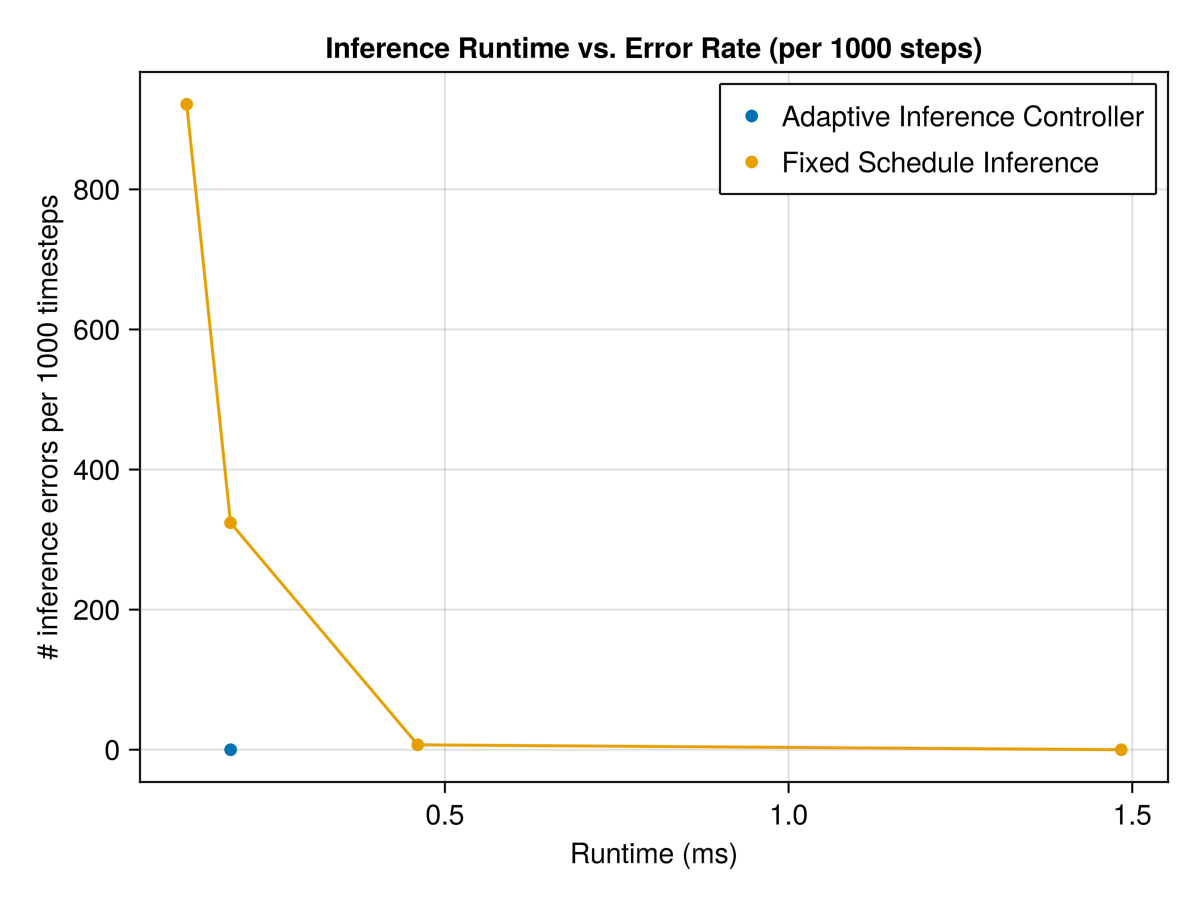

In [86]:
# Results from run on GCloud:
# mean_runtimes_per_group = [[0.3933396353608086], [0.2668472812289283, 0.6494351951848893, 1.5372347902683985], [0.14711248590832665, 0.25978734095891315, 0.5201787494477772]]
# errors_per_thousand_per_group = [[0], [139, 0, 0], [159, 86, 108]]
# grouplabels = [label for (label, _) in ipomdp_rollout_model_groups][1:3]
mean_runtimes_per_group = [[0.18828412471431316], [0.12436486470817339, 0.18806936445802747, 0.4605056503031513, 1.4840321046291012]]#, [0.08083898926725482, 0.10825338434464861, 0.1756189456080446, 0.4702296464750082]]
errors_per_group = [[0], [1843, 648, 14, 0]]#, [1914, 1157, 738, 741]]
total_n = 100 * 20
errors_per_thousand_per_group = [[n_errors / total_n * 1000 for n_errors in X] for X in errors_per_group]
grouplabels = ["Adaptive Inference Controller", "Fixed Schedule Inference"]#; Coarsest Grid Step Size = 0.2", "Fixed Schedule Inference; Coarsest Grid Step Size = 0.4"]

f = Makie.Figure()
ax = Makie.Axis(f[1, 1], title="Inference Runtime vs. Error Rate (per 1000 steps)", xlabel="Runtime (ms)", ylabel="# inference errors per 1000 timesteps")
# for (mean_runtimes, errors_per_thousand, (_, label)) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, ipomdp_rollout_model_groups)
for (mean_runtimes, errors_per_thousand, label) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, grouplabels)
    # plt! = length(mean_runtimes) > 1 ? Makie.lines! : Makie.scatter!
    Makie.scatter!(ax, mean_runtimes, errors_per_thousand, label=label)
    Makie.lines!(ax, mean_runtimes, errors_per_thousand)
end
Makie.axislegend()
f 


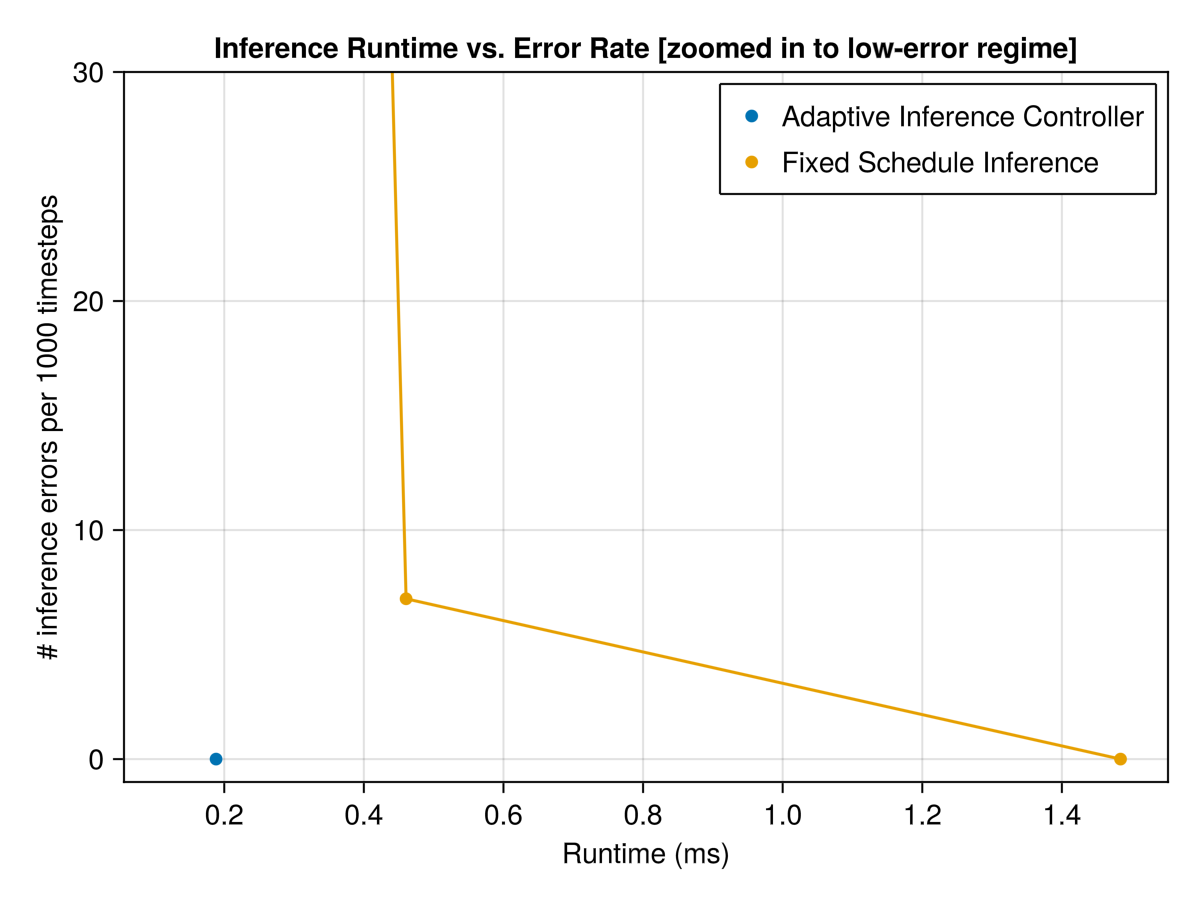

In [87]:
f = Makie.Figure()
ax = Makie.Axis(f[1, 1],
    title="Inference Runtime vs. Error Rate [zoomed in to low-error regime]", xlabel="Runtime (ms)", ylabel="# inference errors per 1000 timesteps",
    xticks=0:0.2:1.6
)
# for (mean_runtimes, errors_per_thousand, (_, label)) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, ipomdp_rollout_model_groups)
for (mean_runtimes, errors_per_thousand, label) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, grouplabels)
    # plt! = length(mean_runtimes) > 1 ? Makie.lines! : Makie.scatter!
    Makie.scatter!(ax, mean_runtimes, errors_per_thousand, label=label)
    Makie.lines!(ax, mean_runtimes, errors_per_thousand)
end
Makie.axislegend()
Makie.ylims!(ax, (-1, 30))
f 

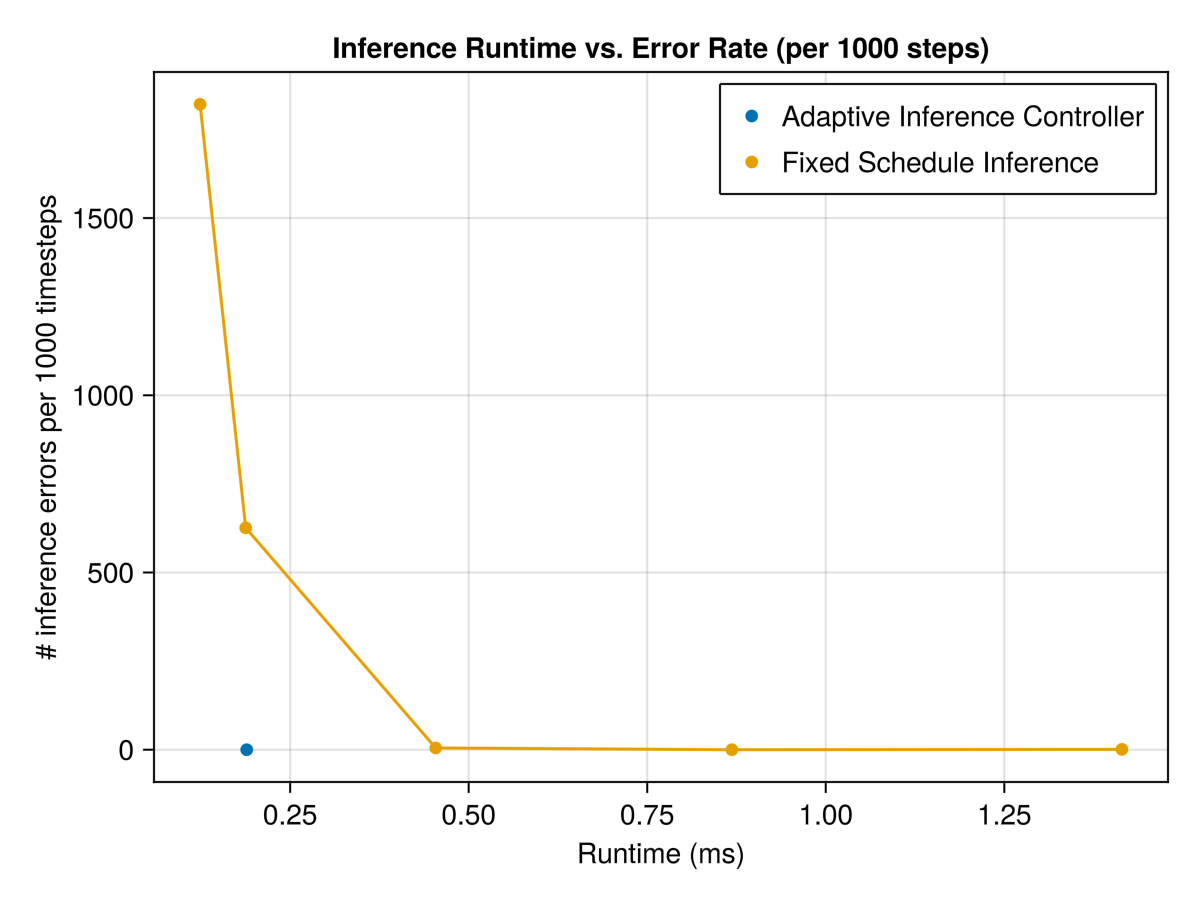

In [82]:
# Results from run on GCloud:
# mean_runtimes_per_group = [[0.3933396353608086], [0.2668472812289283, 0.6494351951848893, 1.5372347902683985], [0.14711248590832665, 0.25978734095891315, 0.5201787494477772]]
# errors_per_thousand_per_group = [[0], [139, 0, 0], [159, 86, 108]]
# grouplabels = [label for (label, _) in ipomdp_rollout_model_groups][1:3]
mean_runtimes_per_group = [[0.18922708872521277], [0.12391899953974356, 0.18782017478848448, 0.453822137695728, 0.8685495312851255, 1.41467761426869]]
errors_per_thousand_per_group = [[0], [1821, 626, 5, 0, 1]] #[[0], [1843, 648, 14, 0], [1914, 1157, 738, 741]]
grouplabels = ["Adaptive Inference Controller", "Fixed Schedule Inference"]#; Coarsest Grid Step Size = 0.2", "Fixed Schedule Inference; Coarsest Grid Step Size = 0.4"]

f = Makie.Figure()
ax = Makie.Axis(f[1, 1], title="Inference Runtime vs. Error Rate (per 1000 steps)", xlabel="Runtime (ms)", ylabel="# inference errors per 1000 timesteps")
# for (mean_runtimes, errors_per_thousand, (_, label)) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, ipomdp_rollout_model_groups)
for (mean_runtimes, errors_per_thousand, label) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, grouplabels)
    # plt! = length(mean_runtimes) > 1 ? Makie.lines! : Makie.scatter!
    Makie.scatter!(ax, mean_runtimes, errors_per_thousand, label=label)
    Makie.lines!(ax, mean_runtimes, errors_per_thousand)
end
Makie.axislegend()
f 


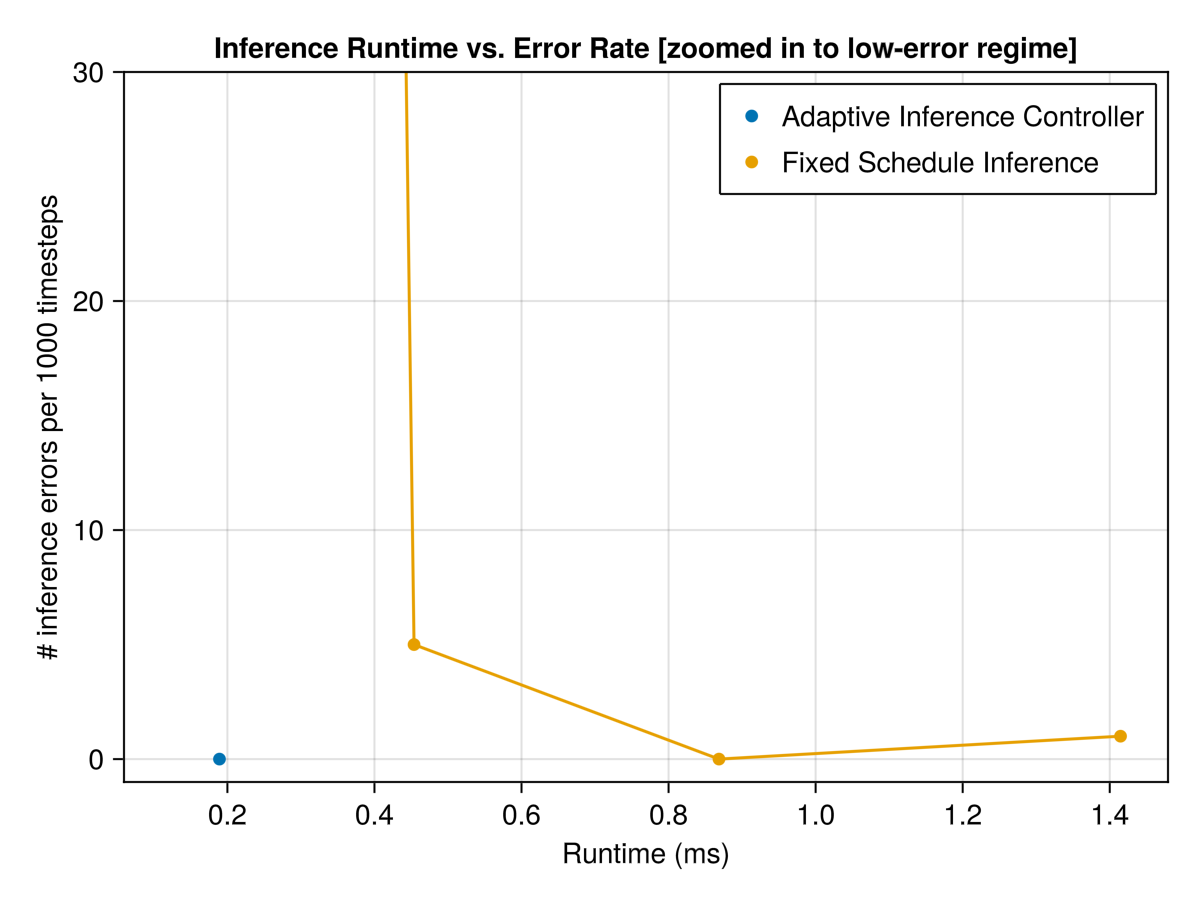

In [83]:
f = Makie.Figure()
ax = Makie.Axis(f[1, 1],
    title="Inference Runtime vs. Error Rate [zoomed in to low-error regime]", xlabel="Runtime (ms)", ylabel="# inference errors per 1000 timesteps",
    xticks=0:0.2:1.6
)
# for (mean_runtimes, errors_per_thousand, (_, label)) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, ipomdp_rollout_model_groups)
for (mean_runtimes, errors_per_thousand, label) in zip(mean_runtimes_per_group, errors_per_thousand_per_group, grouplabels)
    # plt! = length(mean_runtimes) > 1 ? Makie.lines! : Makie.scatter!
    Makie.scatter!(ax, mean_runtimes, errors_per_thousand, label=label)
    Makie.lines!(ax, mean_runtimes, errors_per_thousand)
end
Makie.axislegend()
Makie.ylims!(ax, (-1, 30))
f 

### Inference controller animation

In [52]:
# TODO

### Inference controller with a coarse mental model of the inference POMDP

Now we'll implement an equivalent inference controller to the adaptive one above.  But we will write it so that it thinks of itself as playing in a different inference POMDP than the real one.  The reason we will do this is so it can have a coarse mental model of the POMDP it's playing in, so it can make optimal decisions w.r.t. that model of the inference problem.

In [53]:
# TODO